In [1]:
import json

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv(
    'data/train.csv',
    parse_dates=['date'],
    dtype={'fullVisitorId': str, 'visitId': str},
    converters={key: json.loads for key in ['device', 'geoNetwork', 'totals', 'trafficSource']}
)

df.head(2)

,channelGrouping,date,device,fullVisitorId,geoNetwork,sessionId,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,2016-09-02,"{'browser': 'Chrome', 'browserVersion': 'not a...",9674781571160116268,"{'continent': 'Asia', 'subContinent': 'Southea...",9674781571160116268_1472804607,Not Socially Engaged,"{'visits': '1', 'hits': '1', 'pageviews': '1',...","{'campaign': '(not set)', 'source': 'google', ...",1472804607,1,1472804607
1,Organic Search,2016-09-02,"{'browser': 'Chrome', 'browserVersion': 'not a...",8590648239310839049,"{'continent': 'Europe', 'subContinent': 'Easte...",8590648239310839049_1472835928,Not Socially Engaged,"{'visits': '1', 'hits': '1', 'pageviews': '1',...","{'campaign': '(not set)', 'source': 'google', ...",1472835928,1,1472835928


In [3]:
df.shape

(12283, 12)

In [4]:
len(df.fullVisitorId.unique())

9997

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12283 entries, 0 to 12282
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   channelGrouping       12283 non-null  object        
 1   date                  12283 non-null  datetime64[ns]
 2   device                12283 non-null  object        
 3   fullVisitorId         12283 non-null  object        
 4   geoNetwork            12283 non-null  object        
 5   sessionId             12283 non-null  object        
 6   socialEngagementType  12283 non-null  object        
 7   totals                12283 non-null  object        
 8   trafficSource         12283 non-null  object        
 9   visitId               12283 non-null  object        
 10  visitNumber           12283 non-null  int64         
 11  visitStartTime        12283 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(9)
memory usage: 1.1+ MB


In [6]:
device_df = pd.json_normalize(df.device, max_level=0)
geoNetwork_df = pd.json_normalize(df.geoNetwork, max_level=0)
totals_df = pd.json_normalize(df.totals, max_level=0)
trafficSource_df = pd.json_normalize(df.trafficSource, max_level=0)

In [7]:
df_v1 = pd.concat([df, device_df, geoNetwork_df, totals_df, trafficSource_df], axis=1)
df_v1 = df_v1.drop(columns=['device', 'geoNetwork', 'totals', 'trafficSource', 'adwordsClickInfo'])

df_v1.head(2)

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,browser,browserVersion,...,newVisits,transactionRevenue,campaign,source,medium,keyword,isTrueDirect,referralPath,adContent,campaignCode
0,Organic Search,2016-09-02,9674781571160116268,9674781571160116268_1472804607,Not Socially Engaged,1472804607,1,1472804607,Chrome,not available in demo dataset,...,1,NaN,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN
1,Organic Search,2016-09-02,8590648239310839049,8590648239310839049_1472835928,Not Socially Engaged,1472835928,1,1472835928,Chrome,not available in demo dataset,...,1,NaN,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN


In [8]:
df_v1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12283 entries, 0 to 12282
Data columns (total 49 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   channelGrouping            12283 non-null  object        
 1   date                       12283 non-null  datetime64[ns]
 2   fullVisitorId              12283 non-null  object        
 3   sessionId                  12283 non-null  object        
 4   socialEngagementType       12283 non-null  object        
 5   visitId                    12283 non-null  object        
 6   visitNumber                12283 non-null  int64         
 7   visitStartTime             12283 non-null  int64         
 8   browser                    12283 non-null  object        
 9   browserVersion             12283 non-null  object        
 10  browserSize                12283 non-null  object        
 11  operatingSystem            12283 non-null  object        
 12  oper

In [9]:
columns_unique = np.array([len(df_v1[column].unique()) for column in df_v1.columns])
columns_unique

array([    8,   366,  9997, 12276,     1, 12272,    50, 12279,    22,
           1,     1,    12,     1,     2,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     3,     6,    22,   145,
         212,    53,   296,     1,  1747,     1,     1,     1,     1,
          96,    75,     2,     2,   147,     7,    76,     7,   129,
           2,   198,    16,     2])

In [10]:
df_v2 = df_v1.loc[:, ~(columns_unique == 1)].copy(deep=True)

In [11]:
quantitative_columns = ['bounces', 'hits', 'newVisits', 'pageviews', 'transactionRevenue']
df_v2[quantitative_columns] = df_v2[quantitative_columns].apply(pd.to_numeric)

In [12]:
df_v2['transactionRevenue'] = df_v2['transactionRevenue'].fillna(0)

In [13]:
df_v2['transactionRevenue'] = df_v2['transactionRevenue'] / 10**6
df_v2.transactionRevenue.value_counts()

0.00     12119
13.59        3
33.59        3
19.19        3
27.19        2
         ...  
24.73        1
6.99         1
14.48        1
95.18        1
25.24        1
Name: transactionRevenue, Length: 147, dtype: int64

In [14]:
df_v3 = df_v2.groupby('fullVisitorId', as_index=False)[quantitative_columns].sum()
df_v3.head()

,fullVisitorId,bounces,hits,newVisits,pageviews,transactionRevenue
0,0002365800130207040,1.0,1,1.0,1,0.0
1,0010286039787739137,0.0,4,1.0,3,0.0
2,0011056874471185769,0.0,2,1.0,2,0.0
3,0014443856125569702,1.0,1,1.0,1,0.0
4,0017260116665815114,0.0,2,0.0,2,0.0


In [15]:
df_v3.shape

(9997, 6)

In [16]:
X = df_v3.drop(columns=['transactionRevenue', 'fullVisitorId'])
Y = df_v3.transactionRevenue.copy()

In [17]:
from sklearn.model_selection import train_test_split

SEED = 42

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=SEED)

In [18]:
from sklearn.linear_model import LinearRegression

LR = LinearRegression()
LR.fit(x_train, y_train)

LinearRegression()

In [19]:
LR.score(x_test, y_test)

0.21767748999635073

<AxesSubplot:>

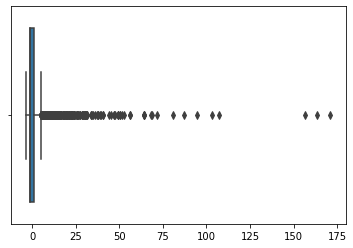

In [20]:
predicted = LR.predict(x_test)

sns.boxplot(x=predicted)

<AxesSubplot:xlabel='transactionRevenue'>

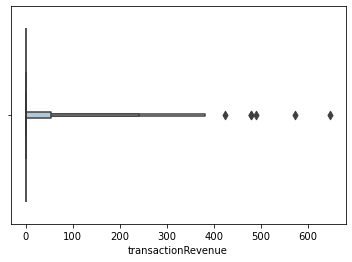

In [21]:
sns.boxenplot(x=y_test)

In [22]:
last_visit_df = df_v2.sort_values('visitNumber', ascending=False).groupby('fullVisitorId').first()
first_visit_df = df_v2.sort_values('visitNumber').groupby('fullVisitorId').first()

In [23]:
first_visit_df.head(3)

,channelGrouping,date,sessionId,visitId,visitNumber,visitStartTime,browser,operatingSystem,isMobile,deviceCategory,...,newVisits,transactionRevenue,campaign,source,medium,keyword,isTrueDirect,referralPath,adContent,campaignCode
fullVisitorId,,,,,,,,,,,,,,,,,,,,,
0002365800130207040,Social,2016-09-04,0002365800130207040_1472974804,1472974804,1,1472974804,Edge,Windows,False,desktop,...,1.0,0.0,(not set),youtube.com,referral,None,None,/yt/about/ru/,None,None
0010286039787739137,Organic Search,2016-09-28,0010286039787739137_1475084026,1475084026,1,1475084026,Chrome,Chrome OS,False,desktop,...,1.0,0.0,(not set),google,organic,(not provided),None,None,None,None
0011056874471185769,Social,2016-12-05,0011056874471185769_1480996024,1480996024,1,1480996024,Chrome,Windows,False,desktop,...,1.0,0.0,(not set),youtube.com,referral,None,None,/yt/about/,None,None


In [24]:
last_visit_df.head(3)

,channelGrouping,date,sessionId,visitId,visitNumber,visitStartTime,browser,operatingSystem,isMobile,deviceCategory,...,newVisits,transactionRevenue,campaign,source,medium,keyword,isTrueDirect,referralPath,adContent,campaignCode
fullVisitorId,,,,,,,,,,,,,,,,,,,,,
0002365800130207040,Social,2016-09-04,0002365800130207040_1472974804,1472974804,1,1472974804,Edge,Windows,False,desktop,...,1.0,0.0,(not set),youtube.com,referral,None,None,/yt/about/ru/,None,None
0010286039787739137,Organic Search,2016-09-28,0010286039787739137_1475084026,1475084026,1,1475084026,Chrome,Chrome OS,False,desktop,...,1.0,0.0,(not set),google,organic,(not provided),None,None,None,None
0011056874471185769,Social,2016-12-05,0011056874471185769_1480996024,1480996024,1,1480996024,Chrome,Windows,False,desktop,...,1.0,0.0,(not set),youtube.com,referral,None,None,/yt/about/,None,None


In [25]:
df_v4 = first_visit_df.join(last_visit_df, on='fullVisitorId', lsuffix='__first', rsuffix='__last').reset_index()
df_v4.head()

,fullVisitorId,channelGrouping__first,date__first,sessionId__first,visitId__first,visitNumber__first,visitStartTime__first,browser__first,operatingSystem__first,isMobile__first,...,newVisits__last,transactionRevenue__last,campaign__last,source__last,medium__last,keyword__last,isTrueDirect__last,referralPath__last,adContent__last,campaignCode__last
0,0002365800130207040,Social,2016-09-04,0002365800130207040_1472974804,1472974804,1,1472974804,Edge,Windows,False,...,1.0,0.0,(not set),youtube.com,referral,None,None,/yt/about/ru/,None,None
1,0010286039787739137,Organic Search,2016-09-28,0010286039787739137_1475084026,1475084026,1,1475084026,Chrome,Chrome OS,False,...,1.0,0.0,(not set),google,organic,(not provided),None,None,None,None
2,0011056874471185769,Social,2016-12-05,0011056874471185769_1480996024,1480996024,1,1480996024,Chrome,Windows,False,...,1.0,0.0,(not set),youtube.com,referral,None,None,/yt/about/,None,None
3,0014443856125569702,Social,2016-10-02,0014443856125569702_1475423502,1475423502,1,1475423502,Opera,Windows,False,...,1.0,0.0,(not set),youtube.com,referral,None,None,/yt/about/ro/,None,None
4,0017260116665815114,Direct,2017-04-20,0017260116665815114_1492707286,1492707286,6,1492707286,Safari,Macintosh,False,...,NaN,0.0,(not set),(direct),(none),None,True,None,None,None


In [26]:
df_v4.columns

Index(['fullVisitorId', 'channelGrouping__first', 'date__first',
       'sessionId__first', 'visitId__first', 'visitNumber__first',
       'visitStartTime__first', 'browser__first', 'operatingSystem__first',
       'isMobile__first', 'deviceCategory__first', 'continent__first',
       'subContinent__first', 'country__first', 'region__first',
       'metro__first', 'city__first', 'networkDomain__first', 'hits__first',
       'pageviews__first', 'bounces__first', 'newVisits__first',
       'transactionRevenue__first', 'campaign__first', 'source__first',
       'medium__first', 'keyword__first', 'isTrueDirect__first',
       'referralPath__first', 'adContent__first', 'campaignCode__first',
       'channelGrouping__last', 'date__last', 'sessionId__last',
       'visitId__last', 'visitNumber__last', 'visitStartTime__last',
       'browser__last', 'operatingSystem__last', 'isMobile__last',
       'deviceCategory__last', 'continent__last', 'subContinent__last',
       'country__last', 'region

In [27]:
df_v4.shape

(9997, 61)

In [28]:
new_quantitative_columns = []

for column in quantitative_columns:
    new_quantitative_columns.append(column + '__first')
    new_quantitative_columns.append(column + '__last')

new_quantitative_columns

['bounces__first',
 'bounces__last',
 'hits__first',
 'hits__last',
 'newVisits__first',
 'newVisits__last',
 'pageviews__first',
 'pageviews__last',
 'transactionRevenue__first',
 'transactionRevenue__last']

In [29]:
df_v5 = df_v4.drop(columns=new_quantitative_columns)
df_v5.head(2)

,fullVisitorId,channelGrouping__first,date__first,sessionId__first,visitId__first,visitNumber__first,visitStartTime__first,browser__first,operatingSystem__first,isMobile__first,...,city__last,networkDomain__last,campaign__last,source__last,medium__last,keyword__last,isTrueDirect__last,referralPath__last,adContent__last,campaignCode__last
0,0002365800130207040,Social,2016-09-04,0002365800130207040_1472974804,1472974804,1,1472974804,Edge,Windows,False,...,not available in demo dataset,wildpark.net,(not set),youtube.com,referral,None,None,/yt/about/ru/,None,None
1,0010286039787739137,Organic Search,2016-09-28,0010286039787739137_1475084026,1475084026,1,1475084026,Chrome,Chrome OS,False,...,Kansas City,(not set),(not set),google,organic,(not provided),None,None,None,None


In [30]:
df_v5 = df_v5.drop(columns=[
    'sessionId__first', 'visitId__first', 'sessionId__last', 'visitId__first',
    'city__first', 'continent__first', 'country__first', 'subContinent__first', 'region__first', 'metro__first', 'networkDomain__first',
]).set_index('fullVisitorId')
df_v5.head(2)

,channelGrouping__first,date__first,visitNumber__first,visitStartTime__first,browser__first,operatingSystem__first,isMobile__first,deviceCategory__first,campaign__first,source__first,...,city__last,networkDomain__last,campaign__last,source__last,medium__last,keyword__last,isTrueDirect__last,referralPath__last,adContent__last,campaignCode__last
fullVisitorId,,,,,,,,,,,,,,,,,,,,,
0002365800130207040,Social,2016-09-04,1,1472974804,Edge,Windows,False,desktop,(not set),youtube.com,...,not available in demo dataset,wildpark.net,(not set),youtube.com,referral,None,None,/yt/about/ru/,None,None
0010286039787739137,Organic Search,2016-09-28,1,1475084026,Chrome,Chrome OS,False,desktop,(not set),google,...,Kansas City,(not set),(not set),google,organic,(not provided),None,None,None,None


In [31]:
df_v3 = df_v3.set_index('fullVisitorId')
df_v3.head()

,bounces,hits,newVisits,pageviews,transactionRevenue
fullVisitorId,,,,,
0002365800130207040,1.0,1,1.0,1,0.0
0010286039787739137,0.0,4,1.0,3,0.0
0011056874471185769,0.0,2,1.0,2,0.0
0014443856125569702,1.0,1,1.0,1,0.0
0017260116665815114,0.0,2,0.0,2,0.0


In [32]:
df_v6 = df_v5.join(df_v3)
df_v6.head()

,channelGrouping__first,date__first,visitNumber__first,visitStartTime__first,browser__first,operatingSystem__first,isMobile__first,deviceCategory__first,campaign__first,source__first,...,keyword__last,isTrueDirect__last,referralPath__last,adContent__last,campaignCode__last,bounces,hits,newVisits,pageviews,transactionRevenue
fullVisitorId,,,,,,,,,,,,,,,,,,,,,
0002365800130207040,Social,2016-09-04,1,1472974804,Edge,Windows,False,desktop,(not set),youtube.com,...,None,None,/yt/about/ru/,None,None,1.0,1,1.0,1,0.0
0010286039787739137,Organic Search,2016-09-28,1,1475084026,Chrome,Chrome OS,False,desktop,(not set),google,...,(not provided),None,None,None,None,0.0,4,1.0,3,0.0
0011056874471185769,Social,2016-12-05,1,1480996024,Chrome,Windows,False,desktop,(not set),youtube.com,...,None,None,/yt/about/,None,None,0.0,2,1.0,2,0.0
0014443856125569702,Social,2016-10-02,1,1475423502,Opera,Windows,False,desktop,(not set),youtube.com,...,None,None,/yt/about/ro/,None,None,1.0,1,1.0,1,0.0
0017260116665815114,Direct,2017-04-20,6,1492707286,Safari,Macintosh,False,desktop,(not set),(direct),...,None,True,None,None,None,0.0,2,0.0,2,0.0


In [33]:
df_v6['time_fiff'] = df_v6.visitStartTime__last - df_v6.visitStartTime__first
df_v6['visits_count'] = df_v2.groupby('fullVisitorId').count().visitNumber.values

In [34]:
df_v6.head()

,channelGrouping__first,date__first,visitNumber__first,visitStartTime__first,browser__first,operatingSystem__first,isMobile__first,deviceCategory__first,campaign__first,source__first,...,referralPath__last,adContent__last,campaignCode__last,bounces,hits,newVisits,pageviews,transactionRevenue,time_fiff,visits_count
fullVisitorId,,,,,,,,,,,,,,,,,,,,,
0002365800130207040,Social,2016-09-04,1,1472974804,Edge,Windows,False,desktop,(not set),youtube.com,...,/yt/about/ru/,None,None,1.0,1,1.0,1,0.0,0,1
0010286039787739137,Organic Search,2016-09-28,1,1475084026,Chrome,Chrome OS,False,desktop,(not set),google,...,None,None,None,0.0,4,1.0,3,0.0,0,1
0011056874471185769,Social,2016-12-05,1,1480996024,Chrome,Windows,False,desktop,(not set),youtube.com,...,/yt/about/,None,None,0.0,2,1.0,2,0.0,0,1
0014443856125569702,Social,2016-10-02,1,1475423502,Opera,Windows,False,desktop,(not set),youtube.com,...,/yt/about/ro/,None,None,1.0,1,1.0,1,0.0,0,1
0017260116665815114,Direct,2017-04-20,6,1492707286,Safari,Macintosh,False,desktop,(not set),(direct),...,None,None,None,0.0,2,0.0,2,0.0,0,1


In [35]:
df_v6['date_last_year'] = df_v6.date__last.dt.year
df_v6['date_last_month'] = df_v6.date__last.dt.month
df_v6['date_last_day'] = df_v6.date__last.dt.day

df_v6['date_first_year'] = df_v6.date__first.dt.year
df_v6['date_first_month'] = df_v6.date__first.dt.month
df_v6['date_first_day'] = df_v6.date__first.dt.day

In [36]:
df_v6 = df_v6.reset_index().drop(columns=['fullVisitorId', 'date__first', 'date__last'])

In [37]:
df_v6.head()

,channelGrouping__first,visitNumber__first,visitStartTime__first,browser__first,operatingSystem__first,isMobile__first,deviceCategory__first,campaign__first,source__first,medium__first,...,pageviews,transactionRevenue,time_fiff,visits_count,date_last_year,date_last_month,date_last_day,date_first_year,date_first_month,date_first_day
0,Social,1,1472974804,Edge,Windows,False,desktop,(not set),youtube.com,referral,...,1,0.0,0,1,2016,9,4,2016,9,4
1,Organic Search,1,1475084026,Chrome,Chrome OS,False,desktop,(not set),google,organic,...,3,0.0,0,1,2016,9,28,2016,9,28
2,Social,1,1480996024,Chrome,Windows,False,desktop,(not set),youtube.com,referral,...,2,0.0,0,1,2016,12,5,2016,12,5
3,Social,1,1475423502,Opera,Windows,False,desktop,(not set),youtube.com,referral,...,1,0.0,0,1,2016,10,2,2016,10,2
4,Direct,6,1492707286,Safari,Macintosh,False,desktop,(not set),(direct),(none),...,2,0.0,0,1,2017,4,20,2017,4,20


In [38]:
X = df_v6.drop(columns=['transactionRevenue'])
Y = df_v6.transactionRevenue.copy()

In [39]:
qualitative_columns = X.dtypes[(X.dtypes == object) | (X.dtypes == bool)].keys()
qualitative_columns

Index(['channelGrouping__first', 'browser__first', 'operatingSystem__first',
       'isMobile__first', 'deviceCategory__first', 'campaign__first',
       'source__first', 'medium__first', 'keyword__first',
       'isTrueDirect__first', 'referralPath__first', 'adContent__first',
       'campaignCode__first', 'channelGrouping__last', 'visitId__last',
       'browser__last', 'operatingSystem__last', 'isMobile__last',
       'deviceCategory__last', 'continent__last', 'subContinent__last',
       'country__last', 'region__last', 'metro__last', 'city__last',
       'networkDomain__last', 'campaign__last', 'source__last', 'medium__last',
       'keyword__last', 'isTrueDirect__last', 'referralPath__last',
       'adContent__last', 'campaignCode__last'],
      dtype='object')

In [40]:
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict

d = defaultdict(LabelEncoder)

X_encoded = X.apply(lambda x: d[x.name].fit_transform(x) if x.name in qualitative_columns else x)

In [41]:
# X_encoded.apply(lambda x: d[x.name].inverse_transform(x) if x.name in qualitative_columns else x)

In [42]:
x_train, x_test, y_train, y_test = train_test_split(X_encoded, Y, test_size=0.3, random_state=SEED)

LR = LinearRegression()
LR.fit(x_train, y_train)

LR.score(x_test, y_test)

0.22039187239816516

In [46]:
from sklearn.metrics import mean_squared_error

predicted = LR.predict(x_test)
predicted[predicted < 0] = 0

In [47]:
mean_squared_error(y_test, predicted)

621.7001827514499

In [48]:
np.sqrt(mean_squared_error(y_test, predicted))

24.93391631395778

In [55]:
from sklearn.ensemble import GradientBoostingRegressor

GBR = GradientBoostingRegressor(random_state=SEED)
GBR.fit(x_train, y_train)

GBR.score(x_test, y_test)

0.2653913168938592

In [56]:
predicted = GBR.predict(x_test)
predicted[predicted < 0] = 0

In [57]:
np.sqrt(mean_squared_error(y_test, predicted))

24.329026540093192